In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from collections import Counter
import jieba
import jieba.posseg as pseg
print(tf.__version__)

1.0.1


# 作业1

- 用神经网络建模，处理之前的情感分类问题

## 获得词向量

### 定义参数

In [2]:
# 决定了 embedding 的维度 （隐层节点数）
word_embedding_dim = 8
# 决定了词表数量, 预留一个未登录词
vocab_size = 200 + 1
UNK_IDX = 0

In [3]:
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
input_data = tf.placeholder(tf.int32, shape=[None, 2], name='input_data')
input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)
context_embeds = tf.reduce_sum(input_embeds, axis=1)

In [4]:
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, 2, 8) dtype=float32>

In [5]:
word_embedding

In [6]:
# raw_output 是一个 vocab_size 维的数据，对比 labels 计算 cost
# 假设输入一组（也就是 两个词），输出因为词向量相加过了，所以就是一个词的词向量：one-hot？
raw_output = tf.layers.dense(context_embeds, vocab_size)
# 如果输入一组，输出的 softmax 是预测的 one-hot 的概率分布？最可能的那个输出词概率最大？
output = tf.nn.softmax(raw_output)

In [7]:
# 样本的 labels 也需要用 placeholder 放置
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

# 因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。
# 如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels)

### 训练集

In [10]:
!head -5 train_shuffle.txt

������xp������������������������������������������������������������	1
������������,������������,������������������������,������������������.������������.	1
2���������������������������������������	1
���������������������������������������������	1
������6���������"������"���������������^_^���������������������������������������������	1


### 读取并设置 dataset

In [8]:
with open('./train_shuffle.txt', 'r') as f:
    rawdata = f.read().decode('utf-8')

In [9]:
data = rawdata.split('\n')

In [10]:
dataset = []
for w in data:
    dataset.append(w.split('\t'))

In [11]:
dataset[0:3]

[[u'\u88c5\u4e86xp\u7cfb\u7edf\u540e\uff0c\u6ca1\u6709\u51fa\u73b0\u7f51\u53cb\u8bf4\u7684\u9a71\u52a8\u4e0d\u597d\u88c5\u7684\u60c5\u51b5',
  u'1'],
 [u'\u603b\u7684\u6765\u8bf4,\u6bd4\u8f83\u5e72\u51c0,\u800c\u4e14\u5730\u7406\u4f4d\u7f6e\u5f88\u597d,\u5e02\u533a\u7e41\u534e\u5730\u6bb5.\u8fdb\u51fa\u65b9\u4fbf.',
  u'1'],
 [u'2\u3001\u6563\u70ed\u5f88\u597d\uff0c\u8fd9\u4e2a\u4e0d\u7528\u89e3\u91ca\u4e86',
  u'1']]

### 切词代码

In [12]:
def cutset(s):
    words = []
    for w,f in pseg.cut(s.strip()):
        if f == 'x':
            continue
        words.append(w)
    return words

### 生成 sensetcut

In [13]:
# 训练集数量
len(dataset)

24587

In [14]:
sensetcut = []
for i in range(len(dataset)-1):
    tmp = [cutset(dataset[i][0]), int(dataset[i][1])]
    sensetcut.append(tmp)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.437 seconds.
Prefix dict has been built succesfully.


In [15]:
sensetcut[0:2]

[[[u'\u88c5',
   u'\u4e86',
   u'xp',
   u'\u7cfb\u7edf',
   u'\u540e',
   u'\u6ca1\u6709',
   u'\u51fa\u73b0',
   u'\u7f51\u53cb',
   u'\u8bf4',
   u'\u7684',
   u'\u9a71\u52a8',
   u'\u4e0d\u597d',
   u'\u88c5',
   u'\u7684',
   u'\u60c5\u51b5'],
  1],
 [[u'\u603b\u7684\u6765\u8bf4',
   u'\u6bd4\u8f83',
   u'\u5e72\u51c0',
   u'\u800c\u4e14',
   u'\u5730\u7406\u4f4d\u7f6e',
   u'\u5f88',
   u'\u597d',
   u'\u5e02\u533a',
   u'\u7e41\u534e',
   u'\u5730\u6bb5',
   u'\u8fdb\u51fa',
   u'\u65b9\u4fbf'],
  1]]

### 获取所有词

In [16]:
words = []
for s in sensetcut:
    for w in s[0]:
        words.append(w)

In [17]:
len(words)

958177

In [18]:
word_cnt = Counter(words)

In [19]:
len(word_cnt)

37738

### 生成 vocab

In [20]:
vocab = [i[0] for i in word_cnt.most_common(vocab_size - 1)]

In [21]:
vocab2 = [i for i in word_cnt.most_common(vocab_size - 1)]

In [22]:
vocab.insert(UNK_IDX, 'UNK')

In [23]:
len(vocab)

201

### 所有 words 对应 vocab ID

In [24]:
word_ids = [vocab.index(word) if (word in vocab) else 0 for word in words]

In [25]:
len(word_ids)

958177

### 生成词向量训练数据

In [97]:
# 生成训练数据
inputs_train = np.asarray(
                [[word_ids[i-1], word_ids[i+1]] for i in range(1, len(word_ids) - 1)])
labels_train = np.asarray(word_ids[1:-1])

In [98]:
inputs_train.shape

(958175, 2)

In [28]:
labels_train.shape

(958175,)

### 训练词向量

In [37]:
train_step = tf.train.GradientDescentOptimizer(0.000002).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    dummy_feed_dict = {input_data: inputs_train,
                       labels: labels_train}
    for i in range(50):
        sess.run(train_step, feed_dict=dummy_feed_dict)
        if i % 1 == 0:
            print("Iteration %d" % i)
            print("Cost 矩阵：")
            print(cost.eval(feed_dict=dummy_feed_dict))
            print("cost 长度：%d" % len(cost.eval(feed_dict=dummy_feed_dict)))
            # 查看输出中 ID == 30 的概率
            print("Output 长度: %d" % len(output.eval(feed_dict=dummy_feed_dict)[0]))
            print(output.eval(feed_dict=dummy_feed_dict).shape)
            print(output.eval(feed_dict=dummy_feed_dict)[0].shape)
            print("Output 矩阵：")
            print(output.eval(feed_dict=dummy_feed_dict))
            print("Probability: %f" % output.eval(feed_dict=dummy_feed_dict)[1, 30])
            print("------")
            # 词向量是 context_embeds 吗？
            word_embeddings = word_embedding.eval()
            allwords_embedding = context_embeds.eval(feed_dict=dummy_feed_dict)

Iteration 0
Cost 矩阵：
[ 11.87393665   0.01407153  11.37514019 ...,  12.06545067   0.08745562
  12.58885098]
cost 长度：958175
Output 长度: 201
(958175, 201)
(201,)
Output 矩阵：
[[  9.99478161e-01   1.50842070e-05   6.96970983e-06 ...,   3.34162314e-06
    1.37863128e-06   1.90402488e-06]
 [  9.86027002e-01   2.72306585e-04   1.09886219e-04 ...,   7.72144704e-05
    3.96547148e-05   5.41351837e-05]
 [  9.96771991e-01   6.93734619e-05   3.79972116e-05 ...,   2.22389299e-05
    1.04095279e-05   1.10531373e-05]
 ..., 
 [  9.98087347e-01   4.64014702e-05   2.23643237e-05 ...,   1.19593487e-05
    5.64798984e-06   6.59372381e-06]
 [  9.16259527e-01   1.32132694e-03   6.57716941e-04 ...,   4.03517857e-04
    2.74013204e-04   3.47286667e-04]
 [  9.99035239e-01   2.38816556e-05   1.18050284e-05 ...,   6.75735055e-06
    2.76096921e-06   3.68806536e-06]]
Probability: 0.000056
------
Iteration 1
Cost 矩阵：
[ 4.90554047  5.50674343  5.24850607 ...,  5.38871336  5.475986    5.39596701]
cost 长度：958175
Output 

In [38]:
word_embeddings.shape

(201, 8)

In [83]:
# 按 vocab 的字
word_embeddings_dict = dict(zip(vocab,word_embeddings))

In [91]:
len(word_embeddings_dict)

201

In [106]:
# 按 vocab 的 index
word_embeddings_dict2 = dict(zip(range(len(vocab)),word_embeddings))

In [94]:
allwords_embedding[1]

array([ 1.3400557 ,  0.77151883,  0.68381333,  1.00963259,  0.91522551,
        0.80438769,  0.49588862,  1.0741303 ], dtype=float32)

In [39]:
allwords_embedding.shape

(958175, 8)

### 生成训练数据

In [47]:
len(dataset)

24587

In [46]:
# 句子切词结果 + label
len(sensetcut)

24586

In [156]:
len(sensetcut)

24586

In [158]:
sensetcut[0][0]

[u'\u88c5',
 u'\u4e86',
 u'xp',
 u'\u7cfb\u7edf',
 u'\u540e',
 u'\u6ca1\u6709',
 u'\u51fa\u73b0',
 u'\u7f51\u53cb',
 u'\u8bf4',
 u'\u7684',
 u'\u9a71\u52a8',
 u'\u4e0d\u597d',
 u'\u88c5',
 u'\u7684',
 u'\u60c5\u51b5']

In [159]:
train_ids = []
label_ids = []
for s in sensetcut:
    if len(s[0]) < 1:
        continue
    train_ids.append([vocab.index(word) if (word in vocab) else 0 for word in s[0]])
    label_ids.append(s[1])

In [160]:
inputs_trains = np.asarray(train_ids)
labels_trains = np.asarray(label_ids)

In [161]:
inputs_trains.shape

(24582,)

In [162]:
labels_trains.shape

(24582,)

In [192]:
inputs_trains[0:2]

array([[121, 2, 0, 88, 62, 15, 0, 0, 21, 1, 142, 127, 121, 1, 0],
       [0, 32, 0, 76, 0, 5, 17, 0, 0, 0, 0, 95]], dtype=object)

In [193]:
inputs_embeds = []
tmp = np.zeros(8)
for c in inputs_trains:
    for i in c:
        tmp += word_embeddings_dict2[i]
    inputs_embeds.append(tmp)#/len(c))

In [194]:
inputs = np.asarray(inputs_embeds)

In [195]:
inputs.shape

(24582, 8)

In [196]:
labels_trains.shape

(24582,)

### 训练模型

In [197]:
xtrain = np.array(inputs,dtype=np.float32)
ytrain = np.array(labels_trains, dtype=np.float32)

In [198]:
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

In [206]:
x_placeholder = tf.placeholder('float', [None, 8])
y_placeholder = tf.placeholder('float', [None, 1])

n = 2

hidden = tf.layers.dense(inputs=x_placeholder, units=n, activation=tf.tanh)
nn_raw_output = tf.layers.dense(inputs=hidden, units=1, activation=None)
final_output = tf.sigmoid(nn_raw_output)


cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y_placeholder))

train_step = tf.train.GradientDescentOptimizer(0.03).minimize(cost)
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(200):
        # type 可以不指定形式，数据初始读入的时候已经指定
        # 注意 y 为列向量时，这里需要 reshape，可能是因为向量默认是行的
        # 这里 x 传入的是行向量
        feed_dict = {x_placeholder:xtrain.astype(float), y_placeholder:ytrain.reshape(len(ytrain),1).astype(float)}
        sess.run(train_step, feed_dict=feed_dict)
        cost_value = sess.run(cost, feed_dict=feed_dict)
        costs.append(cost_value)
        if i % 20 == 0:
            preds = sess.run(final_output, feed_dict=feed_dict)
            # accuracy 也需要 reshape，原因也是因为向量默认是行的
            print(accuracy(preds, ytrain.reshape(len(ytrain),1)))

0.471198437881
0.471198437881
0.471198437881
0.528801562119
0.528801562119
0.528801562119
0.528801562119
0.528801562119
0.528801562119
0.528801562119


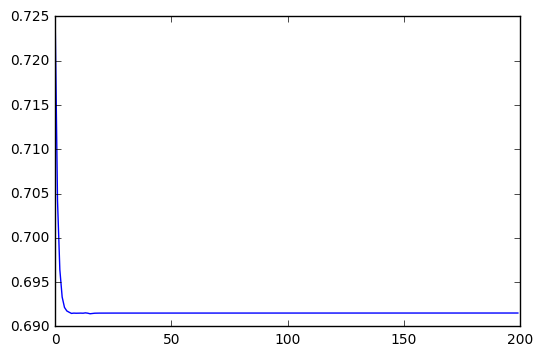

In [204]:
plt.plot(costs)

#### 作业2

- 将 NN Language Model 的 cost 下降情况用 summary + tensorboard 的方式进行可视化
- 收集 Word embedding 的 histogram 并进行可视化

见 task2

#### 作业3

- 使用一个能够平滑图像的二维卷积对图像进行处理
- 应用卷积神经网络实现情感分类
  - 标准化格式，能够读取格式固定的训练、测试数据，跑出 Accuracy 和 Confusion Matrix 结果

见 task3